### Probablistic LSTM Modal

In [14]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [15]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


# data_norm.head(10)

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

In [17]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor = data_tensor[:10000]

In [19]:
class GaussianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GaussianLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mean = nn.Linear(hidden_size, output_size)  # Output mean
        self.fc_variance = nn.Linear(hidden_size, output_size)  # Output variance

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        mean = self.fc_mean(out[:, -1, :])  # Mean of the Gaussian distribution
        variance = torch.exp(self.fc_variance(out[:, -1, :]))  # Variance (apply exp to ensure positivity)
        return mean, variance

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian LSTM model
class GaussianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GaussianLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mean = nn.Linear(hidden_size, output_size)  # Output mean
        self.fc_variance = nn.Linear(hidden_size, output_size)  # Output variance

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        mean = self.fc_mean(out[:, -1, :])  # Mean of the Gaussian distribution
        variance = torch.exp(self.fc_variance(out[:, -1, :]))  # Variance (apply exp to ensure positivity)
        return mean, variance

# Train the model
def train_model(model, criterion, optimizer, data_sequences_tensor, target_labels, num_epochs=100):
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        mean, variance = model(data_sequences_tensor)
        loss = criterion(target_labels, mean, variance)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return losses

# Define negative log likelihood loss for Gaussian distribution
def gaussian_nll_loss(y_true, mean, variance):
    return torch.mean(0.5 * torch.log(variance) + 0.5 * ((y_true - mean) ** 2) / variance)

# Make predictions and calculate upper and lower bounds
def predict(model, data_sequences_tensor):
    mean, variance = model(data_sequences_tensor)
    std_dev = torch.sqrt(variance)
    upper_bound = mean + 2 * std_dev  # 95% confidence interval
    lower_bound = mean - 2 * std_dev  # 95% confidence interval
    return mean, upper_bound, lower_bound



# Parameters
input_size = 1
hidden_size = 10
num_layers = 2
output_size = 1
sequence_length = 15
num_epochs = 1000
learning_rate = 0.001

# Instantiate the model and move to GPU
model = GaussianLSTM(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data with sequence length
data_sequences_tensor = torch.cat([data_tensor[:, i:i+sequence_length, :] for i in range(len(data) - sequence_length)], dim=0)

# Convert data sequences to PyTorch tensors and move to GPU
data_sequences_tensor = data_sequences_tensor.to(device)

# Target labels (using next data point as label for simplicity)
target_labels = data_tensor[:, sequence_length:, :][:, -1, :].to(device)

# Train the model
losses = train_model(model, gaussian_nll_loss, optimizer, data_sequences_tensor, target_labels, num_epochs)

Epoch [10/1000], Loss: 0.4157
Epoch [20/1000], Loss: 0.3050
Epoch [30/1000], Loss: 0.1881
Epoch [40/1000], Loss: 0.0550
Epoch [50/1000], Loss: -0.0915
Epoch [60/1000], Loss: -0.2265
Epoch [70/1000], Loss: -0.3156
Epoch [80/1000], Loss: -0.3886
Epoch [90/1000], Loss: -0.4765
Epoch [100/1000], Loss: -0.5732
Epoch [110/1000], Loss: -0.6845
Epoch [120/1000], Loss: -0.8065
Epoch [130/1000], Loss: -0.9339
Epoch [140/1000], Loss: -1.0658
Epoch [150/1000], Loss: -1.1968
Epoch [160/1000], Loss: -1.3186
Epoch [170/1000], Loss: -1.4278
Epoch [180/1000], Loss: -1.5266
Epoch [190/1000], Loss: -1.6183
Epoch [200/1000], Loss: -1.7052
Epoch [210/1000], Loss: -1.7890
Epoch [220/1000], Loss: -1.8705
Epoch [230/1000], Loss: -1.9501
Epoch [240/1000], Loss: -2.0276
Epoch [250/1000], Loss: -2.1031
Epoch [260/1000], Loss: -2.1766
Epoch [270/1000], Loss: -2.2483
Epoch [280/1000], Loss: -2.3184
Epoch [290/1000], Loss: -2.3870
Epoch [300/1000], Loss: -2.4544
Epoch [310/1000], Loss: -2.5207
Epoch [320/1000], Los

In [46]:
#### save trained modal
torch.save(model.state_dict(), './TrainedModals/LSTM_1M_1000epoch_2.pth')


In [44]:

# Make predictions
mean_pred, upper_bound_pred, lower_bound_pred = predict(model, data_sequences_tensor)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.98 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 10.73 GiB is allocated by PyTorch, and 1019.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

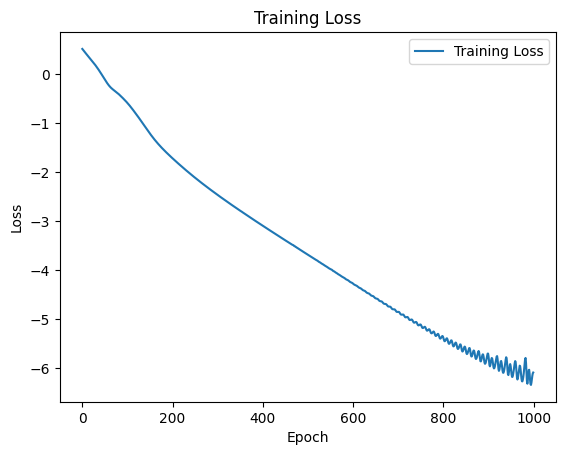

In [45]:
# Plot loss function within epochs
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
data

,timestamp,open,high,low,close
0,2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06970
1,2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966
2,2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06970
3,2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972
4,2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972
...,...,...,...,...,...
322632,2023-12-29 16:54:00,1.10388,1.10390,1.10387,1.10387
322633,2023-12-29 16:55:00,1.10389,1.10395,1.10387,1.10387
322634,2023-12-29 16:56:00,1.10394,1.10394,1.10367,1.10367
322635,2023-12-29 16:57:00,1.10366,1.10366,1.10366,1.10366


In [48]:
upper_bound_pred.squeeze().cpu().detach().numpy()

array([1.10829  , 1.10829  , 1.1082898, ..., 1.1082646, 1.1082647,
       1.1082647], dtype=float32)

In [49]:
lower_bound_pred

tensor([[1.1014],
        [1.1014],
        [1.1014],
        ...,
        [1.1014],
        [1.1014],
        [1.1014]], device='cuda:0', grad_fn=<SubBackward0>)

In [50]:
data.close

0         1.06970
1         1.06966
2         1.06970
3         1.06972
4         1.06972
           ...   
322632    1.10387
322633    1.10387
322634    1.10367
322635    1.10366
322636    1.10361
Name: close, Length: 322637, dtype: float64

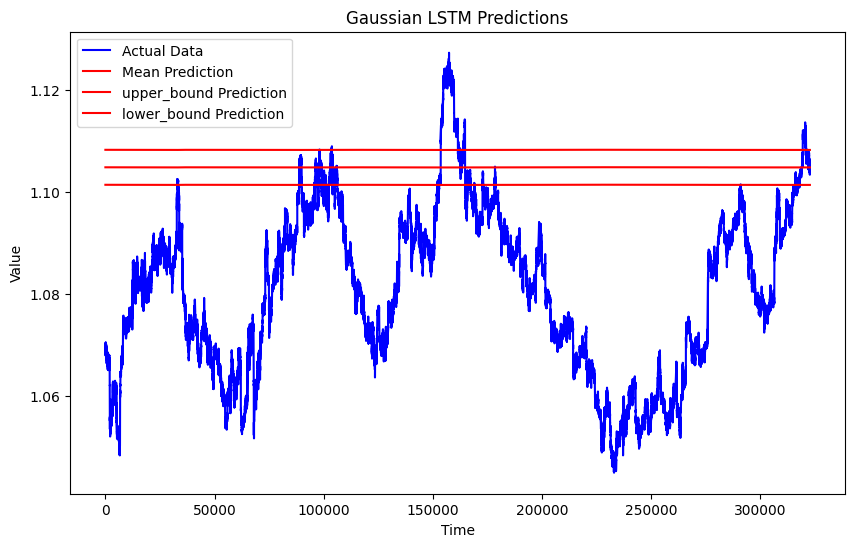

In [51]:
# Plot predictions
def plot_predictions(data, mean, upper_bound, lower_bound):
    # data = data.flatten()
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'], label='Actual Data', color='blue')
    plt.plot(mean, label='Mean Prediction', color='red')
    plt.plot(upper_bound, label='upper_bound Prediction', color='red')
    plt.plot(lower_bound, label='lower_bound Prediction', color='red')
    # plt.fill_between(range(len(mean)), upper_bound, lower_bound, color='orange', alpha=0.3, label='95% Confidence Interval')
    plt.title('Gaussian LSTM Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(data, mean_pred.squeeze().cpu().detach().numpy(), 
                  upper_bound_pred.squeeze().cpu().detach().numpy(), 
                  lower_bound_pred.squeeze().cpu().detach().numpy())

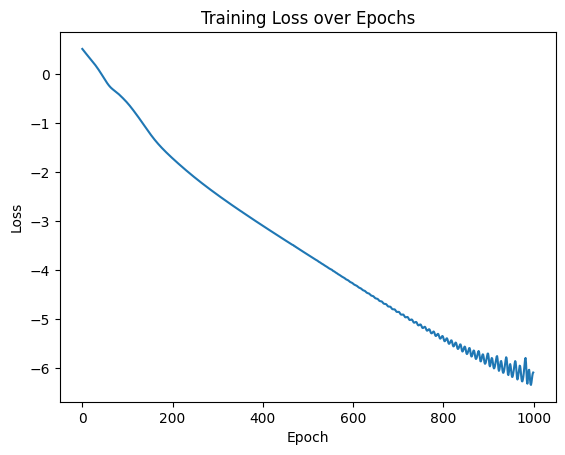

In [52]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Save PyTorch model
# torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')


In [53]:
# import matplotlib.pyplot as plt

# # Select a subset of 1000 timestamps
# subset_df = predictions_df.iloc[0:100]

# # Plot close price
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['Timestamp'], data['close'][0:100], label='Close Price', color='black')

# # Add dots to show predictions
# for index, row in subset_df.iterrows():
#     if row['Probability (Up)'] > 0.5:  # Upward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='green', label='Predicted Up', zorder=1)
#     else:  # Downward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='red', label='Predicted Down', zorder=1)

# plt.title('Close Price and Predicted Movements')
# plt.xlabel('Timestamp (Hourly)')
# plt.ylabel('Close Price')
# plt.xticks(subset_df['Timestamp'][::100], rotation=45, ha='right')  # Show every 10th timestamp for better readability
# plt.tight_layout()
# plt.show()


NameError: name 'predictions_df' is not defined